In [1]:
import seaborn as sns
import imageio
import importlib
from PIL import Image
import matplotlib.pyplot as plt
import math
import torch
import nopdb
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.plotting import plot_attention_cloud

# 1. Build models

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [3]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [5]:
# Load an image to condition on.
img = Image.open('example_data/tablechair.jpeg')

def sample_from_model(breakpoint):
    samples = None
    k = 0
    with nopdb.capture_call(base_model.backbone.resblocks[-1].attn.attention.forward) as attn_call:
        for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
            if x.shape[2] == 1024:
                samples = x
                if k == breakpoint:
                    break
                k += 1
            else:
                break
    scale = 1 / math.sqrt(math.sqrt(attn_call.locals['attn_ch']))

    new_q = attn_call.locals['q'][0].permute(1,0,2)
    new_k = attn_call.locals['k'][0].permute(1,0,2)
    #print(new_k.shape)
    #print(new_q.shape)

    attention_scores = torch.einsum("b i d, b j d -> b i j", new_q, new_k) * scale
    attention_probs = attention_scores.softmax(dim=-1)
    
    # Average across all heads
    avg_attn = torch.mean(attention_probs, dim = 0)
    
    # Est. self attention
    pc_self_attn = avg_attn[257:, 257:]
    
    # Est. cross attention
    pc_cross_attn = avg_attn[:257, 257:]

    pc_self_attn = pc_self_attn.cpu()
    pc_cross_attn = pc_cross_attn.cpu()
    avg_attn = avg_attn.cpu()
    
    return pc_self_attn, pc_cross_attn, avg_attn, samples

In [6]:
breakpoints = [0, 10, 20, 30, 40, 50, 60, -1]
time = [0, 1, 2, 3, 4, 5, 6, 7]

0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


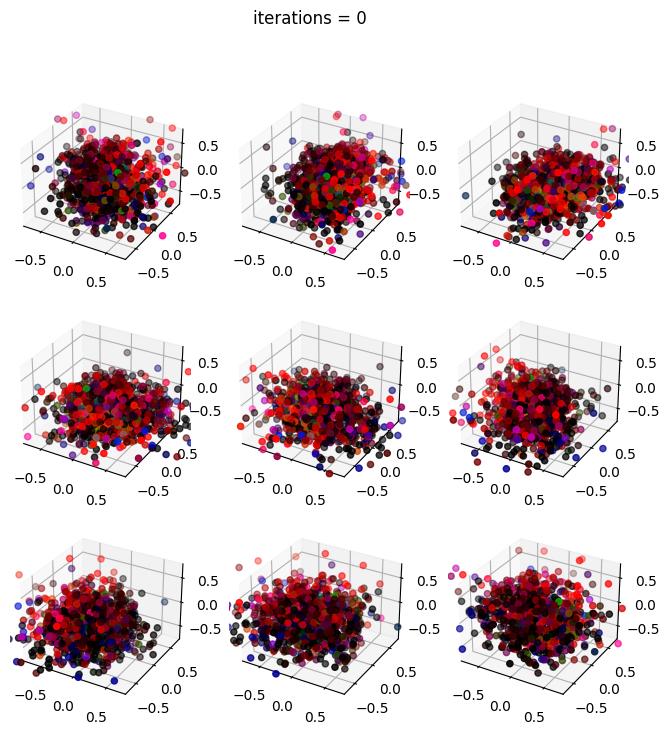

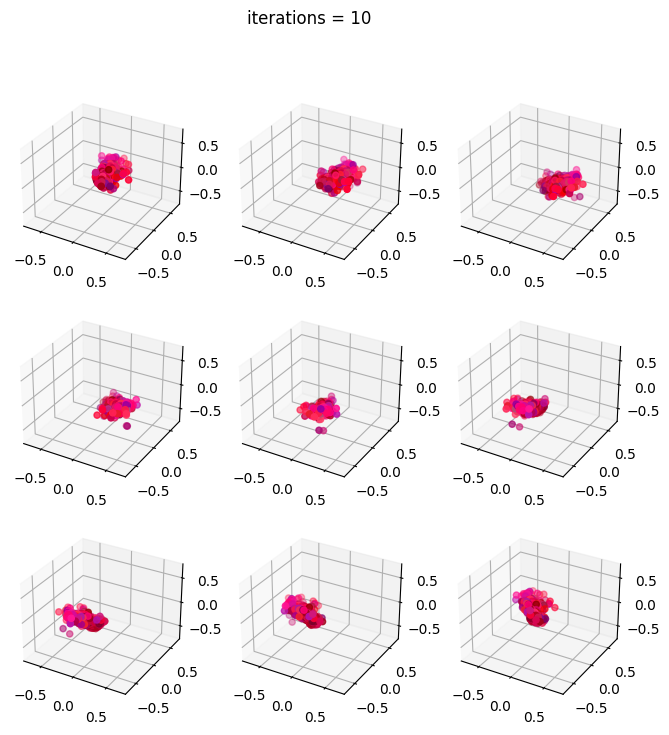

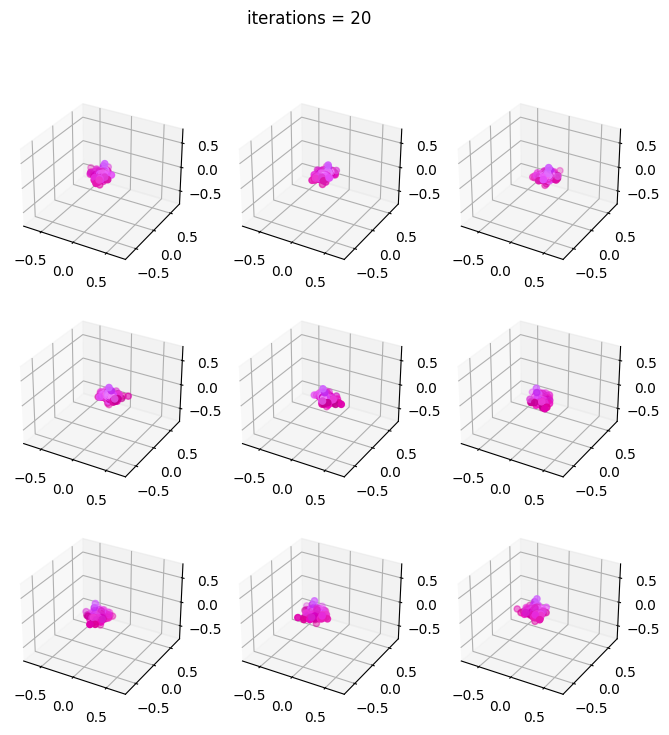

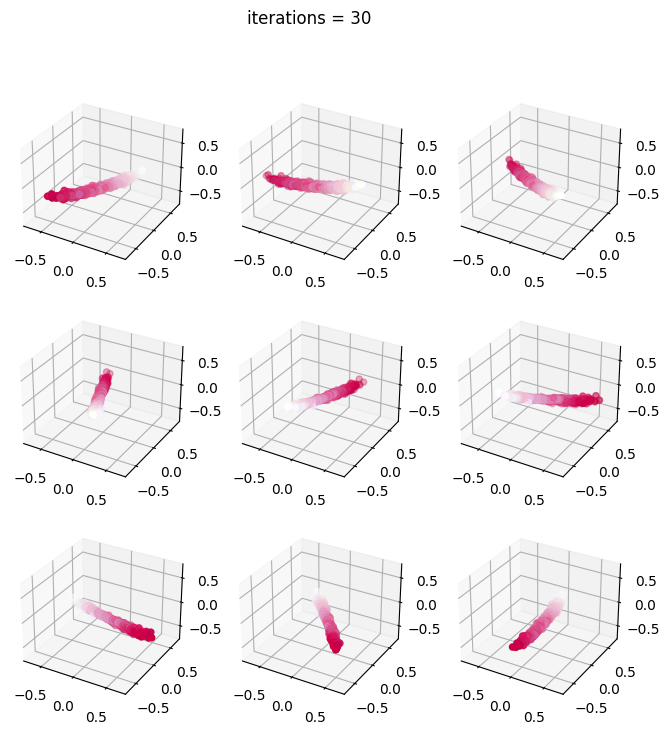

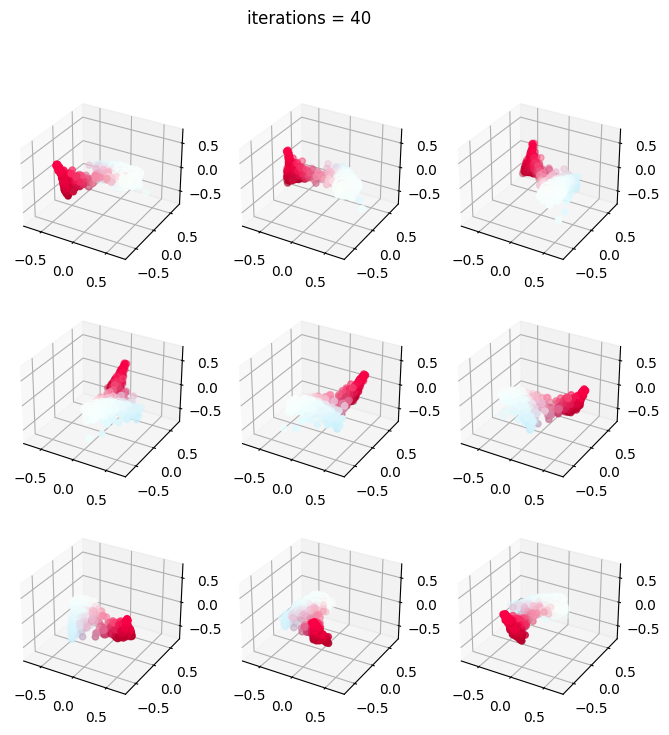

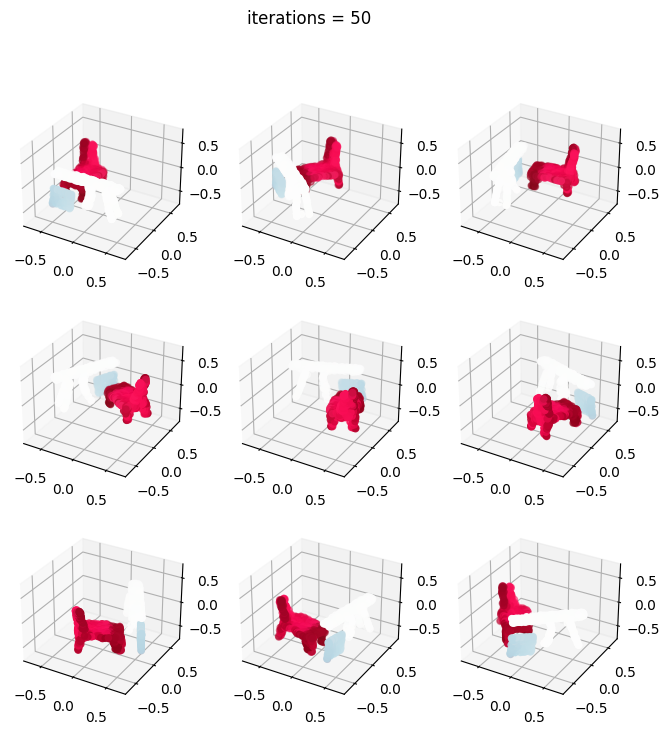

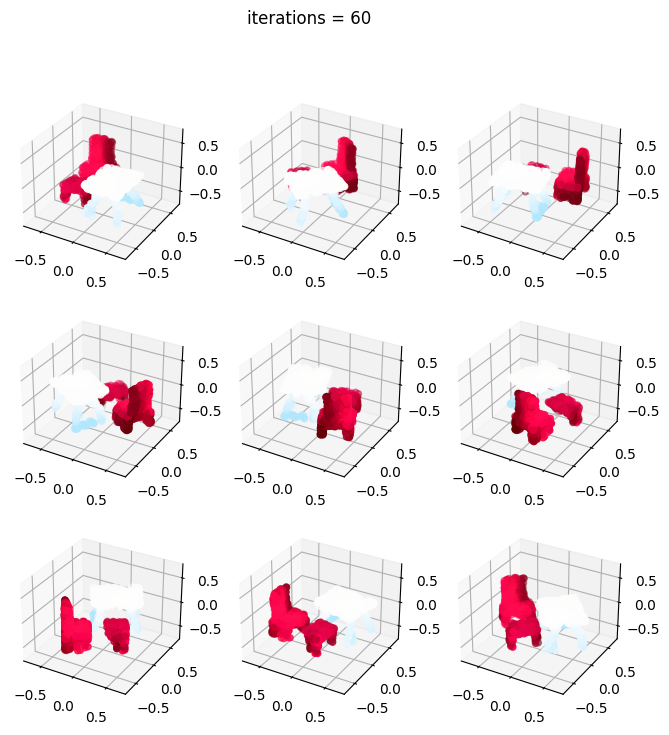

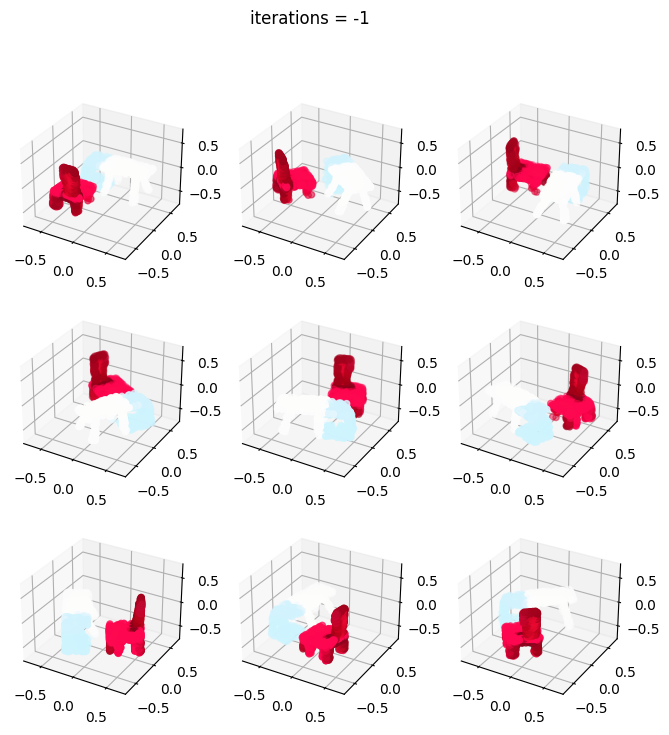

In [7]:
import point_e
importlib.reload(point_e.util.plotting)
from point_e.util.plotting import plot_attention_cloud

frames = []
import numpy as np
for k in breakpoints:
    pc_self_attn, pc_cross_attn, avg_attn, samples = sample_from_model(k)
    pc = sampler.output_to_point_clouds(samples)[0]
    c = np.diagonal(pc_self_attn)
    print(type(c))
    fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))
    fig.suptitle('iterations = ' + str(k))
    plt.savefig('Figures/Diffusion_gif_2/fig' + str(k) + '.png', bbox_inches='tight')
    image = imageio.v2.imread('Figures/Diffusion_gif_2/fig' + str(k) + '.png')
    frames.append(image)
    
    
    
imageio.mimsave('Figures/Diffusion_gif_2/Diffusion_at_scale.gif', # output gif
                frames,          # array of input frames
                fps = 0.5)         # optional: frames per second

# 2. Attention Map Evaluations

## 2.1 Heatmaps

## 2.1.1 2-Dimensions


In [21]:
"""
Make 2D heatmap
"""

frames = []

!mkdir Self_attention
!mkdir Cross_attention
!mkdir Full_attention

for k in breakpoints:
    pc_self_attn, pc_cross_attn, avg_attn, samples = sample_from_model(k)
    
    ax = sns.heatmap(pc_self_attn, cmap = 'rocket_r')
    plt.title('itterations = ' + str(k))
    plt.savefig('Figures/Self_attention/' +str(k) + '.png', bbox_inches='tight')
    plt.close()

    ax = sns.heatmap(pc_cross_attn, cmap = 'rocket_r')
    plt.title('itterations = ' + str(k))
    plt.savefig('Figures/Cross_attention/' +str(k) + '.png', bbox_inches='tight')
    plt.close()
    
    ax = sns.heatmap(avg_attn, cmap = 'rocket_r')
    plt.title('itterations = ' + str(k))
    plt.savefig('Figures/Full_attention/' +str(k) + '.png', bbox_inches='tight')
    plt.close()

     

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
"""
Make Gif
"""

images = ['Figures/Full_attention/' + str(k) + '.png' for k in breakpoints]
frames = []
for t in time:
    image = imageio.v2.imread(images[t])
    frames.append(image)
    
imageio.mimsave('Figures/Full_attention/full_attention.gif', frames, fps = 0.5)

images = ['Figures/Self_attention/' + str(k) + '.png' for k in breakpoints]
frames = []
for t in time:
    image = imageio.v2.imread(images[t])
    frames.append(image)
    
imageio.mimsave('Figures/Self_attention/self_attention.gif', frames, fps = 0.5)

images = ['Figures/Cross_attention/' + str(k) + '.png' for k in breakpoints]
frames = []
for t in time:
    image = imageio.v2.imread(images[t])
    frames.append(image)
    
imageio.mimsave('Figures/Cross_attention/cross_attention.gif', frames, fps = 0.5)

### 2.1.2 3-Dimensions



In [ ]:
import point_e
importlib.reload(point_e.util.plotting)
from point_e.util.plotting import plot_attention_index

frames = []
import numpy as np
for k in breakpoints:
    pc_self_attn, pc_cross_attn, avg_attn, samples = sample_from_model(k)
    pc = sampler.output_to_point_clouds(samples)[0]
    
    fig = plot_attention_index(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)), col = pc_self_attn)
    fig.suptitle('iterations = ' + str(k))
    plt.savefig('Figures/cubes/attention_idx/fig' + str(k) + '.png', bbox_inches='tight')
    image = imageio.v2.imread('Figures/cubes/attention_idx/fig' + str(k) + '.png')
    frames.append(image)
    
    
    
imageio.mimsave('Figures/cubes/attention_idx/attention_idx.gif', # output gif
                frames,          # array of input frames
                fps = 0.5)         # optional: frames per second

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### 2.1.3 Indexbased heatmaps
Look at heatmap in spesific index ranges

In [ ]:
i, j = 250, 270
pc_self_attn = avg_attn[i:j, i:j]

print(pc_self_attn.shape)
pc_self_attn = pc_self_attn.cpu()
import numpy as np
ax = sns.heatmap(pc_self_attn, cmap = 'rocket_r', yticklabels=np.round(np.linspace(i,j,j-i), 0).astype(int), xticklabels=np.round(np.linspace(i,j,j-i).astype(int), 0), vmin = 0, vmax = 0.2)
#plt.show()
plt.savefig('Figures/zoom.png', bbox_inches='tight')

## 2.2 Spectra plots

Plot spectra of attention in index i from all components j

In [ ]:
sns.set_theme()
pc_self_attn, pc_cross_attn, avg_attn, samples = sample_from_model(65)
fig,a =  plt.subplots(2,2)
print(pc_self_attn.shape)
plt.suptitle('Last itteration at downsampled diffusion (65)')
a[0][0].plot(pc_self_attn[0])
a[0][0].set_title('i = 0')
a[0][1].plot(pc_self_attn[500])
a[0][1].set_title('i = 500')
a[1][0].plot(pc_self_attn[1000])
a[1][0].set_title('i = 1000')
a[1][1].plot(pc_self_attn[-1])
a[1][1].set_title('i = 1024')

plt.tight_layout()
#plt.show()
#plt.savefig('Mid_Itteration.png', bbox_inches='tight')

In [ ]:
time = [0, 1, 2]
frames = []
images = ['First_Itteration.png', 'Mid_Itteration.png', 'Last_Itteration.png']
for t in time:
    image = imageio.v2.imread(images[t])
    frames.append(image)
    
imageio.mimsave('evolve.gif', # output gif
                frames,          # array of input frames
                fps = 0.5)         # optional: frames per second

In [ ]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

plt.savefig('fig.png', bbox_inches='tight')

## 2.3 Code to plot colored attention clouds 

In [ ]:
import point_e
importlib.reload(point_e.util.plotting)
from point_e.util.plotting import plot_attention_cloud

frames = []
import numpy as np
for k in breakpoints:
    pc_self_attn, pc_cross_attn, avg_attn, samples = sample_from_model(k)
    pc = sampler.output_to_point_clouds(samples)[0]
    c = np.diagonal(pc_self_attn)
    print(type(c))
    fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))
    fig.suptitle('iterations = ' + str(k))
    plt.savefig('Figures/Diffusion_gif_2/fig' + str(k) + '.png', bbox_inches='tight')
    image = imageio.v2.imread('Figures/Diffusion_gif_2/fig' + str(k) + '.png')
    frames.append(image)
    
    
    
imageio.mimsave('Figures/Diffusion_gif_2/Diffusion_at_scale.gif', # output gif
                frames,          # array of input frames
                fps = 0.5)         # optional: frames per second

0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


0it [00:00, ?it/s]

<class 'numpy.ndarray'>


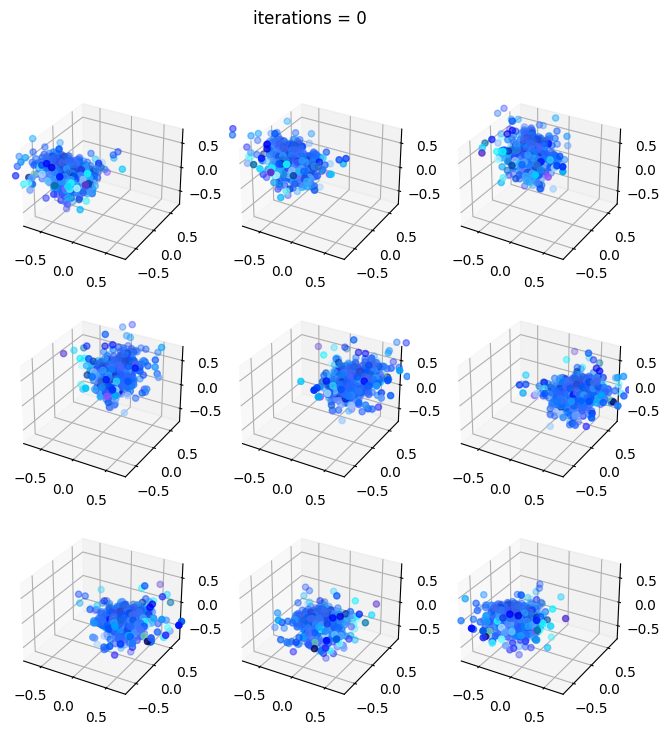

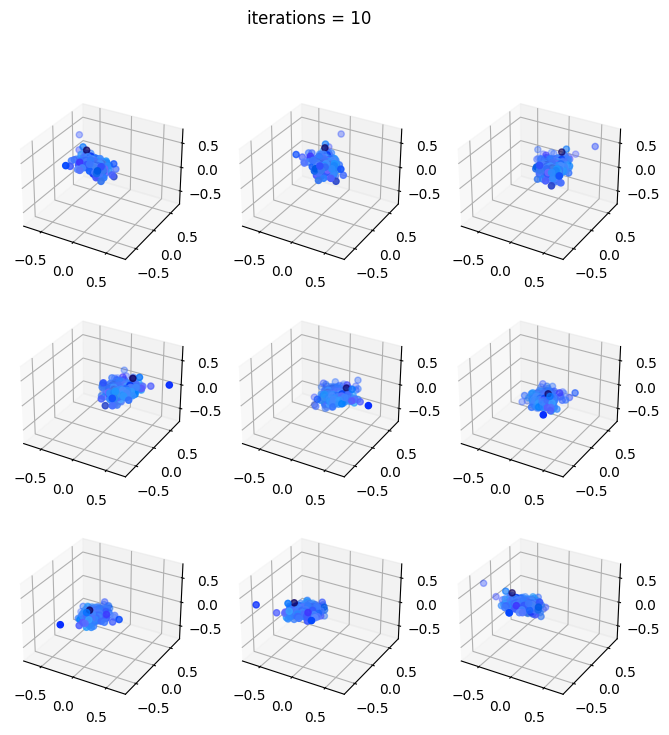

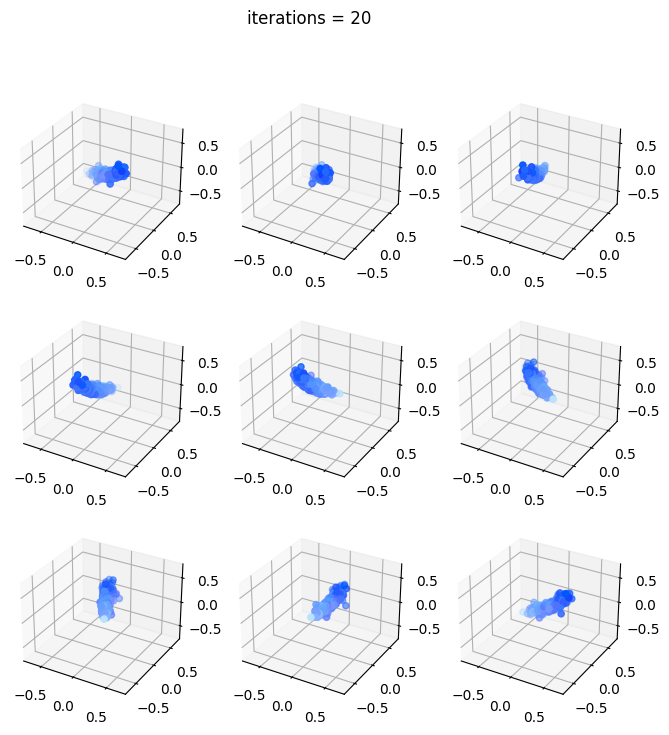

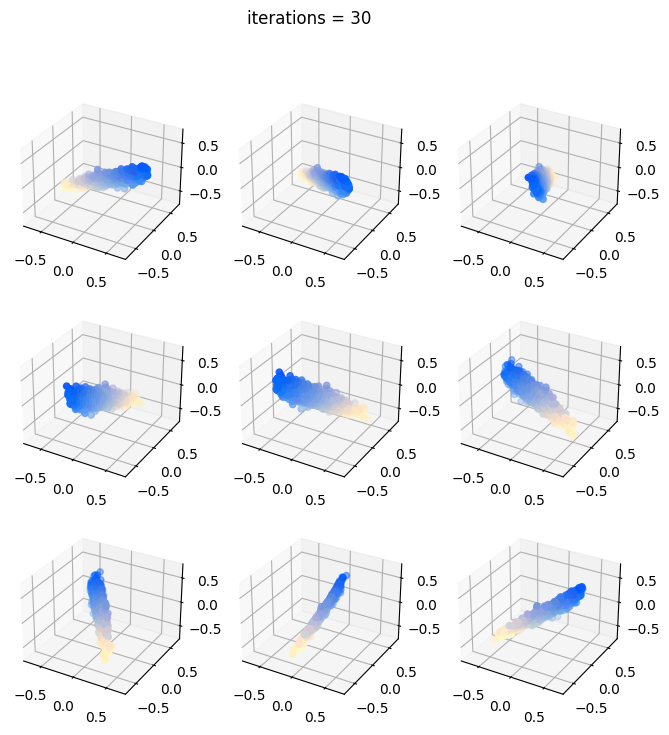

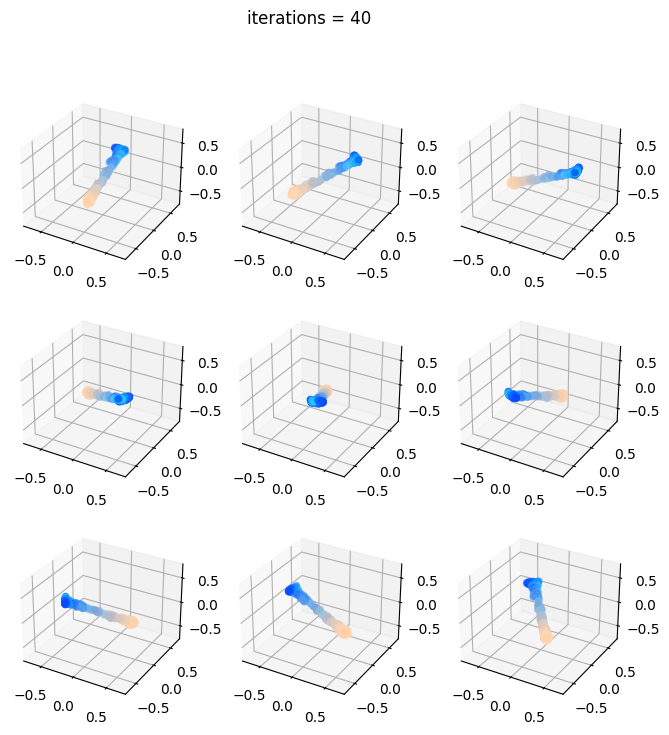

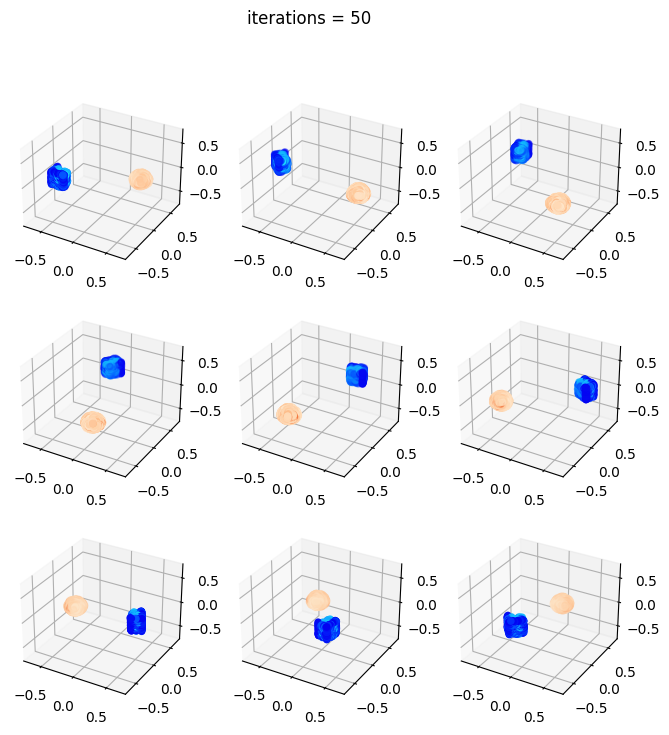

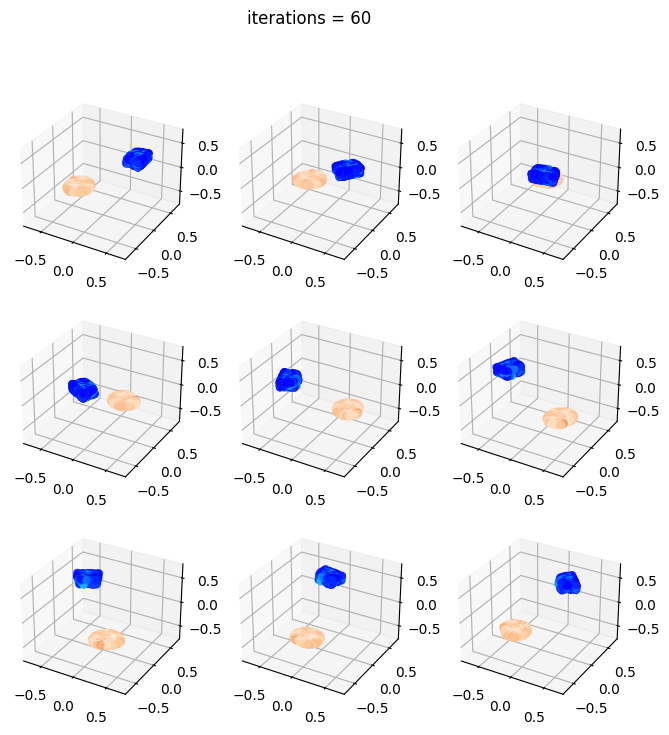

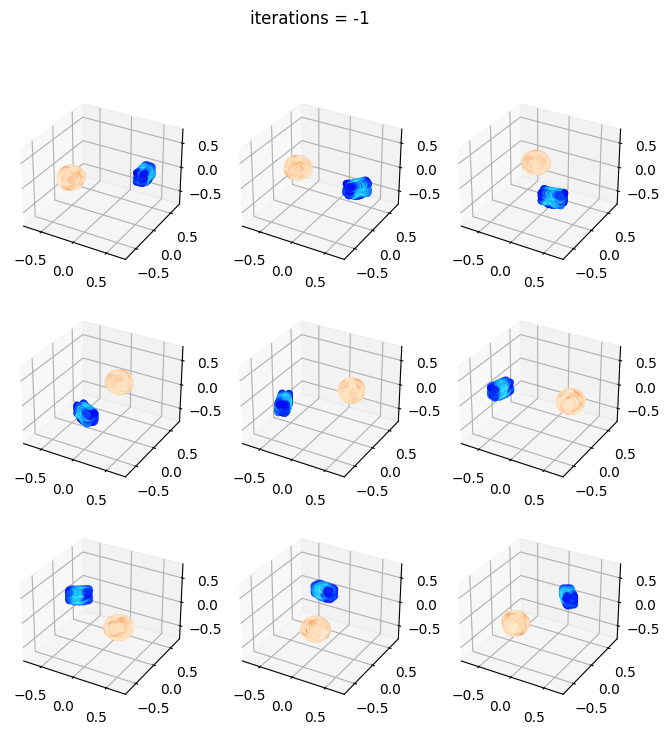

In [20]:
import point_e
importlib.reload(point_e.util.plotting)
from point_e.util.plotting import plot_attention_cloud

frames = []
import numpy as np
for k in breakpoints:
    pc_self_attn, pc_cross_attn, avg_attn, samples = sample_from_model(k)
    pc = sampler.output_to_point_clouds(samples)[0]
    c = np.diagonal(pc_self_attn)
    print(type(c))
    fig = plot_attention_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)), col = c)
    fig.suptitle('iterations = ' + str(k))
    plt.savefig('Figures/Diffusion_gif_2/fig' + str(k) + '.png', bbox_inches='tight')
    image = imageio.v2.imread('Figures/Diffusion_gif_2/fig' + str(k) + '.png')
    frames.append(image)
    
    
    
imageio.mimsave('Figures/Diffusion_gif_2/Diffusion_at_scale.gif', # output gif
                frames,          # array of input frames
                fps = 0.5)         # optional: frames per second

## 2.4 Point Tracker


In [ ]:
breakpoints = [i*2 for i in range(0,33)]
print(breakpoints)
time = [i for i in range(len(breakpoints))]
print(time)

In [ ]:
importlib.reload(point_e.util.plotting)
from point_e.util.plotting import plot_attention_cloud

frames = []
import numpy as np
for k in breakpoints:
    pc_self_attn, pc_cross_attn, avg_attn, samples = sample_from_model(k)
    pc = sampler.output_to_point_clouds(samples)[0]
    c = np.zeros(1024)
    #c[500] = 1
    fig = plot_attention_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)), col = c, alpha_val = 0.2, track_idx = 500)
    fig.suptitle('iterations = ' + str(k))
    plt.savefig('Figures/Point_tracker/fig' + str(k) + '.png', bbox_inches='tight')
    image = imageio.v2.imread('Figures/Point_tracker/fig' + str(k) + '.png')
    frames.append(image)
    
    
    
imageio.mimsave('Figures/Point_tracker/Diffusion_point_tracker.gif', # output gif
                frames,          # array of input frames
                fps = 2)         # optional: frames per second

## 2.5 Max attention

In [ ]:

importlib.reload(point_e.util.plotting)
from point_e.util.plotting import plot_attention_cloud

frames = []
import numpy as np
for k in breakpoints:
    pc_self_attn, pc_cross_attn, avg_attn, samples = sample_from_model(k)
    pc = sampler.output_to_point_clouds(samples)[0]
    
    c = torch.max(pc_self_attn, dim = 1)[0]
    print(c)
    fig = plot_attention_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)), col = c)
    fig.suptitle('iterations = ' + str(k))
    plt.savefig('Figures/Max_attention/fig' + str(k) + '.png', bbox_inches='tight')
    image = imageio.v2.imread('Figures/Max_attention/fig' + str(k) + '.png')
    frames.append(image)
    
    
    
imageio.mimsave('Figures/Max_attention/Diffusion_at_max.gif', # output gif
                frames,          # array of input frames
                fps = 0.5)         # optional: frames per second

## 2.6 Disco boxes

In [ ]:

importlib.reload(point_e.util.plotting)
from point_e.util.plotting import plot_attention_cloud

pc_self_attn, pc_cross_attn, avg_attn, samples = sample_from_model(65)
pc = sampler.output_to_point_clouds(samples)[0]

In [ ]:

mask = np.ones(pc_self_attn.shape, dtype=bool)
np.fill_diagonal(mask, 0)
print(mask)
#max_value = a[mask].max()

In [ ]:
def build_off_diagonal_mask(off_element):
    mask = np.zeros_like(pc_self_attn)
    k = 0
    for i in range(len(mask)):
        try:
            mask[i+off_element, i] = 1
        except IndexError:
            pass
    for i in reversed(range(off_element)):
        mask[k, -(i+1)] = 1
        k += 1
    return np.sum(mask*pc_self_attn.numpy(), axis = 1)


print(build_off_diagonal_mask(0))



In [ ]:
neighbourhood = np.arange(-100, 100, 5)
print(neighbourhood)
time = [i for i in range(len(neighbourhood))]

In [ ]:

importlib.reload(point_e.util.plotting)
from point_e.util.plotting import plot_attention_cloud

frames = []
import numpy as np
for k in neighbourhood:
    c = build_off_diagonal_mask(k)
    #c = np.diag(pc_self_attn)
    #c[500] = 1
    fig = plot_attention_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)), col = c, alpha_val = 0.5)
    fig.suptitle('off_diagonal_element = ' + str(k))
    plt.savefig('Figures/Disco_box/fig' + str(k) + '.png', bbox_inches='tight')
    image = imageio.v2.imread('Figures/Disco_box/fig' + str(k) + '.png')
    frames.append(image)
    
    
    
imageio.mimsave('Figures/Disco_box/Diffusion_disco.gif', # output gif
                frames,          # array of input frames
                fps = 0.5)         # optional: frames per second